# Test Diffusion Model with Other datasets
### Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa
try:
    from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler
except:
    !pip install audio-diffusion-pytorch


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler

# Utils
import numpy as np
from numpy import ndarray
import logging


# Base Scripts
from Libraries.Utils import *
from MainScripts.Conf import conf

### Config

General

In [2]:
remote_kernel: bool = True #Set to true if using a remote Kernel changes the file structure
model_name: str = "diffusion_full_v1"
training_data_name: str = "training_full_low_res"
full_model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)

Logging

In [3]:
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

Training Params

In [4]:
device: str = "cuda" if torch.cuda.is_available() else "cpu"
n_training_samples: int = 4000
batch_size: int = 12
tensor_dim: list = [batch_size, 1, 224, 416] #B, C, H, W

learning_rate: float = 5e-4
epochs: int = 300
restart_training: bool = True
checkpoint_freq: int = 20

### Data Loading

In [5]:
file: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))[:n_training_samples]
data_loader = create_dataloader(Audio_Data(file), batch_size)
logger.info(f"Data loaded with shape: {file.shape}")

2025-05-26 13:41:46,478 - INFO - Data loaded with shape: (4000, 224, 416)


### Setup

Model Creation

In [6]:
u_net = UNetV0
u_net = DiffusionModel(
    net_t=u_net,
    in_channels = 1,
    channels=[16, 32, 128, 256],
    factors = [2, 2, 2, 2],
    items = [2, 2, 2, 3],
    attentions = [0, 0, 1, 1],
    attention_features = 64,
    attention_heads = 12,
    diffusion_t = VDiffusion,
    sampler_t = VSampler,
    dim=2
).to(device)


Model Loading

In [7]:

optimizer = optim.AdamW(u_net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
start_epoch: int = 0
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    u_net.load_state_dict(model["model"])
    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        scheduler.load_state_dict(model["scheduler"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(u_net)} Parameters")

2025-05-26 13:41:47,612 - INFO - Model diffusion_full_v1 created with 21236834 Parameters


Initiate Trainer

In [8]:
trainer = Trainer(u_net, optimizer, scheduler, device)

### Training

In [ ]:
train_loss, _ = trainer.train(train_dataset=data_loader,
            n_epochs=epochs,
            full_model_path=full_model_path,
            checkpoint_freq=checkpoint_freq
            )
scatter_plot(train_loss)

2025-05-26 13:41:47,813 - INFO - Training started on cuda
2025-05-26 13:43:59,248 - INFO - Epoch 001: Avg. Loss: 3.90554e-01 Remaining Time: 10h 54min 57s LR: 4.99986e-04 
2025-05-26 13:46:06,975 - INFO - Epoch 002: Avg. Loss: 2.76454e-01 Remaining Time: 10h 43min 34s LR: 4.99945e-04 
2025-05-26 13:50:22,134 - INFO - Epoch 004: Avg. Loss: 2.27030e-01 Remaining Time: 10h 34min 19s LR: 4.99781e-04 
2025-05-26 13:52:22,872 - INFO - Epoch 005: Avg. Loss: 2.14385e-01 Remaining Time: 10h 24min 27s LR: 4.99657e-04 
2025-05-26 13:54:23,116 - INFO - Epoch 006: Avg. Loss: 2.09485e-01 Remaining Time: 10h 16min 48s LR: 4.99507e-04 
2025-05-26 13:56:24,101 - INFO - Epoch 007: Avg. Loss: 2.01350e-01 Remaining Time: 10h 11min 17s LR: 4.99329e-04 
2025-05-26 13:58:25,933 - INFO - Epoch 008: Avg. Loss: 2.05492e-01 Remaining Time: 10h 07min 09s LR: 4.99123e-04 
2025-05-26 14:00:29,345 - INFO - Epoch 009: Avg. Loss: 1.94551e-01 Remaining Time: 10h 04min 20s LR: 4.98890e-04 
2025-05-26 14:02:31,025 - INFO

Save Model Architecture

In [ ]:
trainer.save_architecture(tensor_dim, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))

c:\Users\finia\AppData\Local\Programs\Python\Python313\Lib\site-packages\einops\packing.py:148: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  lengths_of_composed_axes: List[int] = [-1 if -1 in p_shape else prod(p_shape) for p_shape in packed_shapes]
c:\Users\finia\AppData\Local\Programs\Python\Python313\Lib\site-packages\einops\packing.py:150: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  n_unknown_composed_axes = sum(int(x == -1) for x in lengths_of_composed_axes)


### Sample

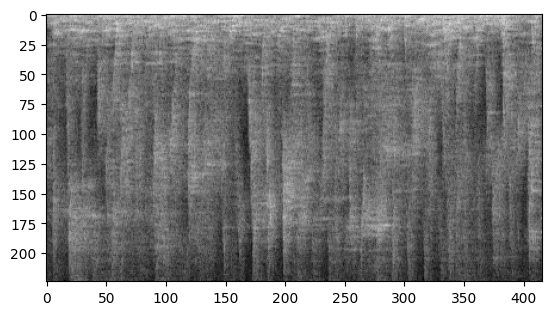

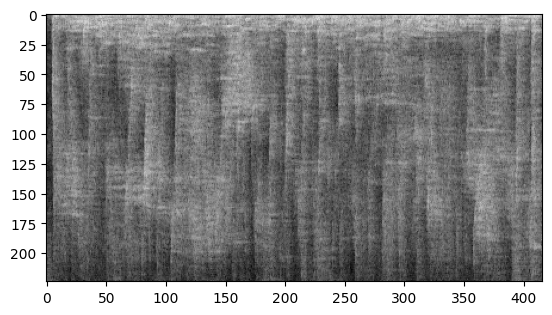

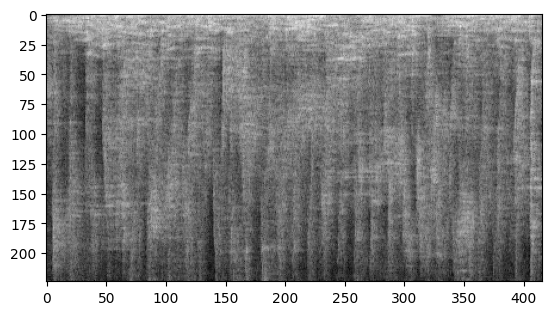

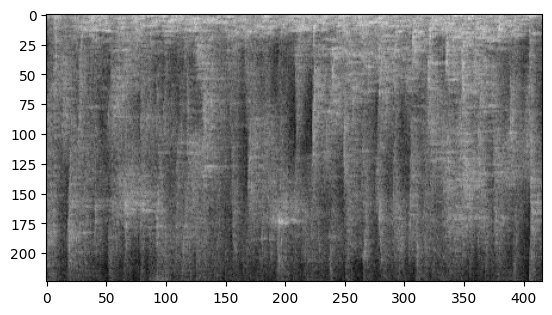

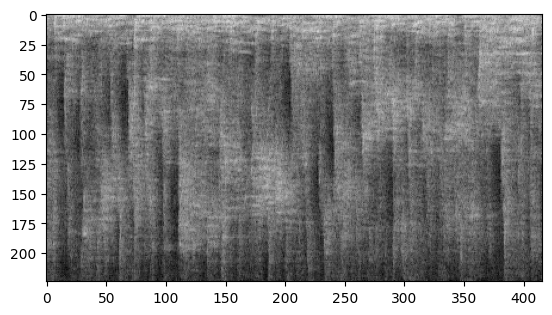

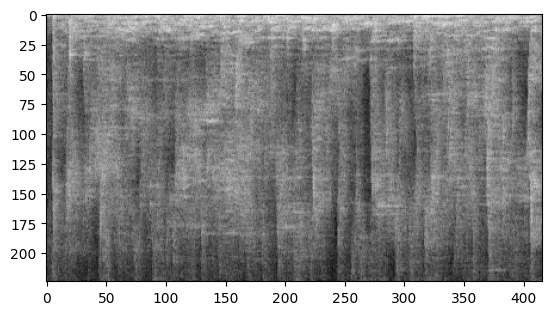

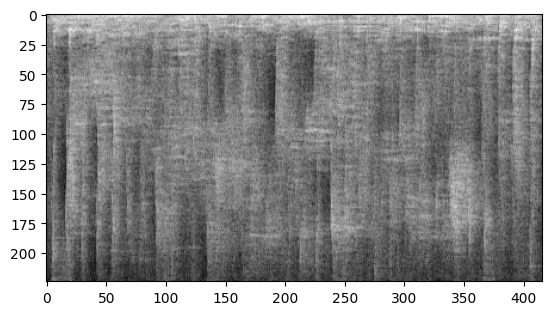

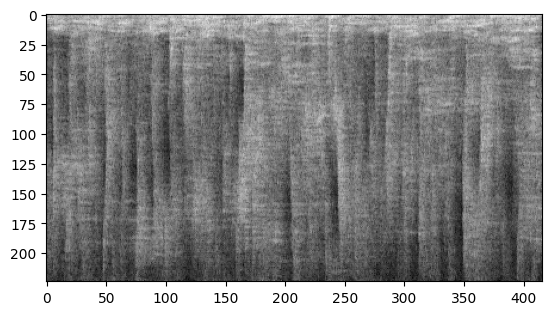

In [ ]:
samples = trainer.sample(8, tensor_dim, 1000, True)

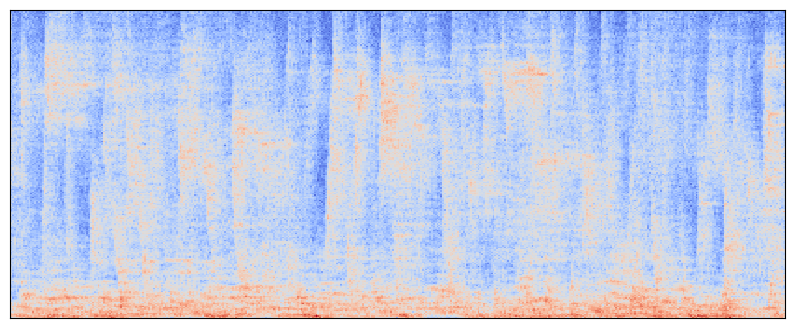

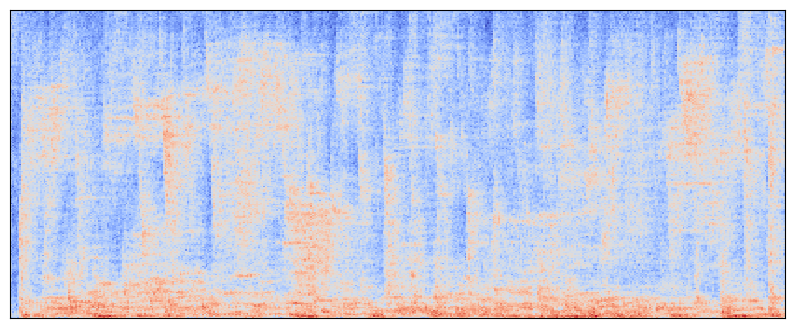

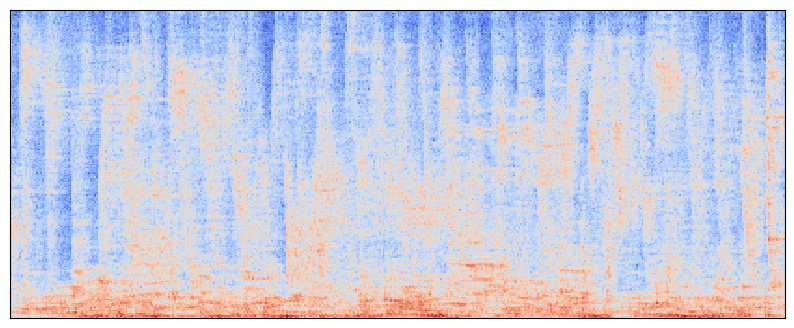

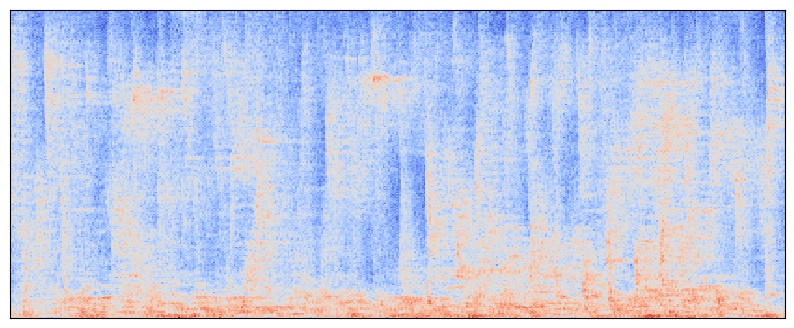

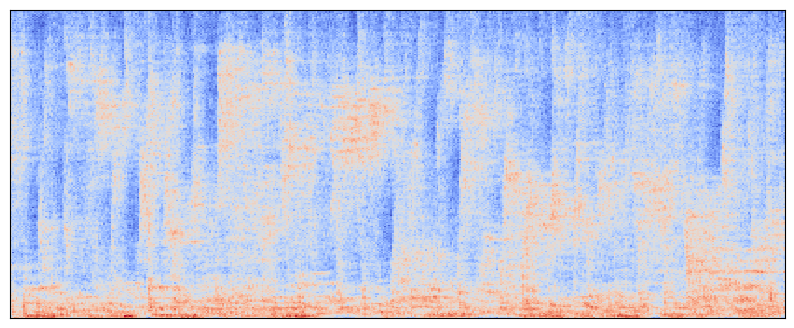

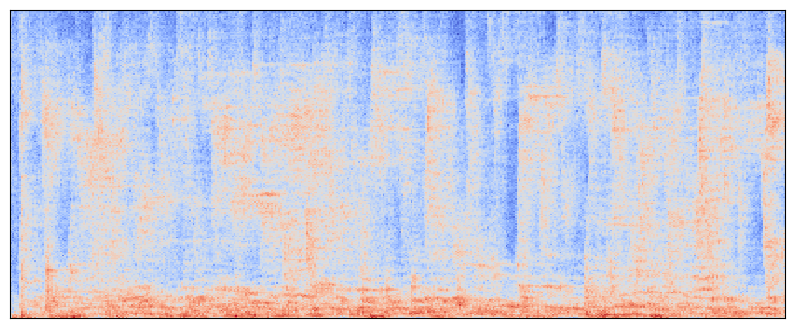

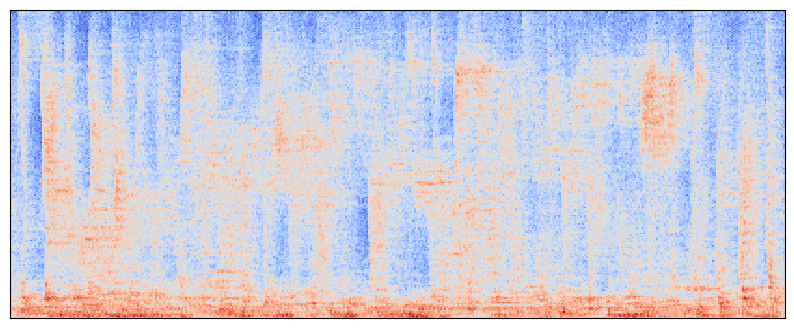

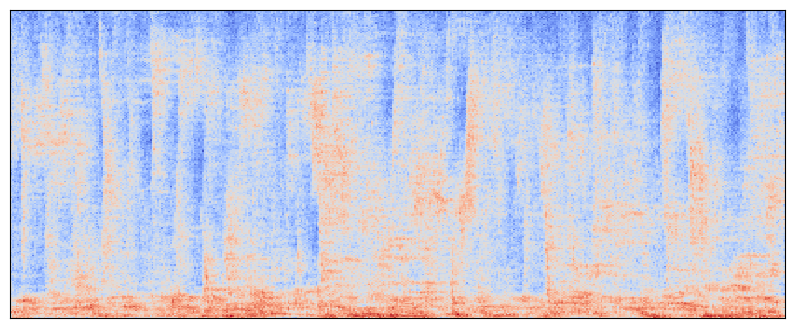

In [ ]:
trainer.save_samples(samples, path_to_remote_path("{}/{}".format(conf["paths"].result_path, "model_result"), remote_kernel))

In [ ]:
avg = 0
avg_sdr = 0
for i in range(100):
    avg_sdr += sdr(file[i], sample_rate=conf["audio"].sample_rate, cutoff=2000)
    avg += spectral_convergence(file[i], sample_rate=conf["audio"].sample_rate, len_fft=conf["audio"].len_fft, hop_length=conf["audio"].len_hop)
print(f"Spectral Convergence: {avg / 100:.05f} SDR: {avg_sdr / 100:.05f}")
avg = 0
avg_sdr = 0
for i in range(samples.shape[0]):
    sample = samples[i,0].cpu().numpy()
    avg += spectral_convergence(sample, sample_rate=conf["audio"].sample_rate, len_fft=conf["audio"].len_fft, hop_length=conf["audio"].len_hop)
    avg_sdr += sdr(sample, sample_rate=conf["audio"].sample_rate, cutoff=2000)
print(f"Spectral Convergence: {avg / samples.shape[0]:.05f} SDR: {avg_sdr / samples.shape[0]:.05f}")

Spectral Convergence: 5.40470 SDR: 4.83316
Spectral Convergence: 6.64285 SDR: 2.82328
